# Pr-YBCO version

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from alris_functions import shift_atoms_p63, transform_list_hkl_p63_p65, get_structure_factors, get_mode_amplitudes_p63
from matplotlib.markers import MarkerStyle
from tqdm import tqdm
from time import time

%config InlineBackend.figure_format = 'svg' # make figures appears in .svg style




num_threads = 2  

# Configure TensorFlow to use multiple threads
tf.config.threading.set_intra_op_parallelism_threads(num_threads)
tf.config.threading.set_inter_op_parallelism_threads(num_threads)

print(f"Using {num_threads} threads for intra-op and inter-op parallelism.")

Using 2 threads for intra-op and inter-op parallelism.


Define the function containing the fitting parameters

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- `fun_tf()` correspond to the **structure factor calculation function** (one has to convert it to a **TF-compatible** function)
- <span style="color:red">If conversion to TF-compatible function is not possible, then this approach will probably not work (or becomes much more tedious at least)</span>

In [3]:
def fun_tf(x, pars):
    """
    Fast computation of structure factors with parameter-dependent structure.
        # Get modified structure
    modified_struct = shift_atoms_p65(*pars)
    neg_h = tf.stack([-x[:, 0], x[:, 1], x[:, 2]], axis=1)
    x_combined = tf.concat([x, neg_h], axis=0)  # Shape [2N, 3]

    x_combined = transform_list_hkl_p63_p65(x_combined)

    # Get structure factors
    sf_combined = get_structure_factors(x_combined, modified_struct)
    # Compute intensity
    # Split and compute intensity
    sf_hkl = sf_combined[:tf.shape(x)[0]]
    sf_neg_k = sf_combined[tf.shape(x)[0]:]
    
    intensity = (tf.abs(sf_hkl) + tf.abs(sf_neg_k)) ** 2
    return intensity / tf.reduce_max(intensity)
    """
    # Get modified structure
    modified_struct = shift_atoms_p63(*pars)
    #neg_h = tf.stack([-x[:, 0], x[:, 1], x[:, 2]], axis=1)
    x_combined = x
    #x_combined = tf.concat([x, neg_h], axis=0)  # Shape [2N, 3]

    x_combined = transform_list_hkl_p63_p65(x_combined)

    # Get structure factors
    sf_combined = get_structure_factors(x_combined, modified_struct)
    # Compute intensity
    # Split and compute intensity
    sf_hkl = sf_combined[:tf.shape(x)[0]]
    
    print(f"Shape of sf_combined: {sf_combined.shape}, Shape of x_combined: {x_combined.shape}")
    
    intensity = (tf.abs(sf_hkl)) ** 2
    w = tf.constant(0.00159, dtype=tf.float32)  # Debye-Waller factor is 0.00159
    qnorms = tf.norm(tf.cast(x_combined[:tf.shape(x)[0]], tf.float32), axis=1)
    # qnorms = tf.reshape(qnorms, (-1, 1))  # Reshape to match the shape of intensity
    intensity = intensity * tf.exp(-w * qnorms ** 2)  # Apply Debye-Waller factor
    return intensity / tf.reduce_max(intensity)


Sample the model parameters (fitting parameters)

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The six parameters correspond to the fractional atomic shifts in the modes w.r.t. unit cell lengths MODIFY THIS PART

In [5]:
#experimental_data = pd.read_csv('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/raw_data/peaks.csv')
experimental_data = pd.read_csv('C:/Users/Calculations/Documents/alris/CrystalClearFit/alrisDistortionFit/raw_data/peaks.csv')

"""
# reduce data to l in [0.5, 1.5, 2.5, 3.5, 4.5 ]
experimental_data = experimental_data[
    (experimental_data["l"] == 0.5) |
    (experimental_data["l"] == 1.5) |
    (experimental_data["l"] == 2.5) |
    (experimental_data["l"] == 3.5) |
    (experimental_data["l"] == 4.5)
]
"""

hkl_list = experimental_data[["h", "k", "l"]].values.tolist()
hkl_list = tf.convert_to_tensor(hkl_list, dtype=tf.float32)
print(experimental_data.shape)
print(hkl_list[0:9])

(217, 5)
tf.Tensor(
[[0.        1.1111112 0.       ]
 [0.        1.2222222 0.       ]
 [0.        1.3333334 0.       ]
 [0.        1.4444444 0.       ]
 [0.        1.5555556 0.       ]
 [0.        1.6666666 0.       ]
 [0.        1.7777778 0.       ]
 [0.        1.8888888 0.       ]
 [0.        2.1111112 0.       ]], shape=(9, 3), dtype=float32)


Sample the "training data" (features and labels)

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The features are the (h,k,l) coordinates (e.g. a vector of size `n_features` x 3, i.e. `n_dim = 3`)
- Maybe one has to normalize the features (i.e. not using integers but floats between -1 (0) and 1)? Before passing them to the structure calculation function, they should be again rescaled to integers
- The labels would be the experimental intensities (again, maybe have to be normalized to the range between 0 and 1)

In [6]:
n_features = experimental_data.shape[0]
n_dim = 3

features = hkl_list
labels = experimental_data["intensity_exp"].tolist()
#labels = tf.convert_to_tensor(labels, dtype=tf.float32)

vol_err = experimental_data["intensity_exp_err"].tolist()
labels_err = []
for label, err in zip(labels, vol_err):
    
    labels_err.append(np.sqrt(label))  # Inverse error

labels = labels / np.max(labels)  # Normalize labels

labels_err = tf.convert_to_tensor(labels_err, dtype=tf.float32)
labels = tf.convert_to_tensor(labels, dtype=tf.float32)

labels = tf.expand_dims(labels, axis=-1)  # Ensure labels are 2D
labels_err = tf.expand_dims(labels_err, axis=-1)  # Ensure labels_err are 2D

print("Max label err:", np.max(labels_err))
print("min label err:", np.min(labels_err))
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)
print('error shape:', labels_err.shape)
print("Max label:", np.max(labels))
print("min label :", np.min(labels))


Max label err: 1.2363877
min label err: 0.12145521
Features shape: (217, 3)
Labels shape: (217, 1)
error shape: (217, 1)
Max label: 1.0
min label : 0.009649902


Define a simple model

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The six parameters (a,b,c,d,e,f) correspond to the fractional atomic shifts in the modes w.r.t. unit cell lengths
- Instead of `sigmoid`, `tanh` should be applied to the parameters before passing them to the structure factor calculation function (ensures smoother gradient landscape)
- The `tanh` function can furthermore be limited to a specific range (e.g. if atomic distortions should not exceed +- 0.1)

In [7]:
class FunAsLayer(tf.keras.layers.Layer):
    def __init__(self, max_par_value= 1, **kwargs):
        super().__init__(**kwargs)
        self.max_par_value = max_par_value

    def build(self, input_shape):
        self.param = self.add_weight(name='param', shape=(445,), initializer=tf.keras.initializers.he_uniform(), trainable=True)
        super().build(input_shape)

    def call(self, inputs):
        # Apply tanh to ensure parameters stay within the [-1, 1] range
        transformed_params = tf.tanh(self.param) * self.max_par_value
        output = fun_tf(inputs, tf.unstack(transformed_params))
        return tf.reshape(output , [-1])  # Ensure output is 1D




Create optimizer and define loss function

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The learning rate must be determined by experimentation (same holds for the batch size and the number of epochs below)
- As a loss function, one can try either MSE or R-score (MSE seems to be the more "natural choice" in this case)

In [8]:
"""
# R-Score based on intensity
class RFactorLoss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        return tf.reduce_sum(tf.abs(y_true - y_pred)) / tf.reduce_sum(y_true)
"""
    
# mean squared error
class PerSampleMSE(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__(reduction=tf.keras.losses.Reduction.NONE)

    def call(self, y_true, y_pred):
        squared_error = tf.square(y_true - y_pred)
        per_sample_mse = tf.reduce_mean(squared_error, axis=-1)
        return per_sample_mse  # shape (batch_size,)

class MSE_weighted(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        # Assume y_true = [labels, errors]
        print('ytrue shape:', y_true.shape)
        print('y true' , y_true)
        labels = y_true[:, 0]
        weights = y_true[:, 1]

        mse = tf.square(labels - y_pred)
        return tf.reduce_sum(mse * weights) / tf.reduce_sum(weights)


# Define the custom metric function
def r_factor_metric(y_true, y_pred):
    labels = y_true
    return tf.reduce_sum(tf.abs(labels - y_pred)) / tf.reduce_sum(labels)


Train the model for n iterations (to try different initial weights)

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The number of iterations defines the "starting position" $w_0$ of the gradient descent algorithm
- Because there are probably many local minima, changing $w_0$ allows the algorithm to find different minima and increases the chances of finding the global minima

labels shape: (217, 1)
labels_err shape: (217, 1)
Learning rate: 0.001
Shape of sf_combined: (None,), Shape of x_combined: (None, 3)
Epoch 1/500
Shape of sf_combined: (217,), Shape of x_combined: (217, 3)
Shape of sf_combined: (217,), Shape of x_combined: (217, 3)
1/1 [==============================] - 28s 28s/step - loss: 0.0134 - r_factor_metric: 1.4577
Epoch 2/500
1/1 [==============================] - 0s 24ms/step - loss: 0.0114 - r_factor_metric: 1.3507
Epoch 3/500
1/1 [==============================] - 0s 23ms/step - loss: 0.0101 - r_factor_metric: 1.2688
Epoch 4/500
1/1 [==============================] - 0s 23ms/step - loss: 0.0093 - r_factor_metric: 1.2047
Epoch 5/500
1/1 [==============================] - 0s 23ms/step - loss: 0.0088 - r_factor_metric: 1.1545
Epoch 6/500
1/1 [==============================] - 0s 23ms/step - loss: 0.0085 - r_factor_metric: 1.1153
Epoch 7/500
1/1 [==============================] - 0s 22ms/step - loss: 0.0082 - r_factor_metric: 1.0842
Epoch 8/500


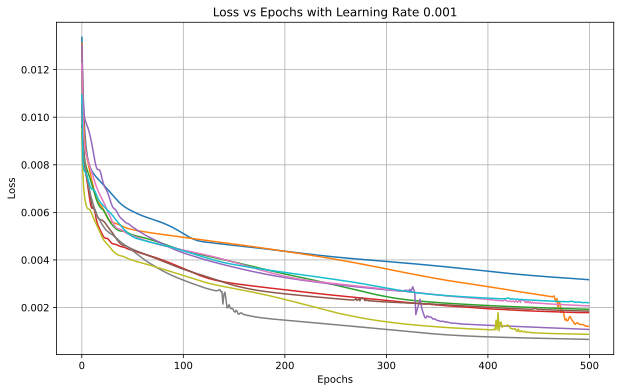

In [14]:
print("labels shape:", labels.shape)
print("labels_err shape:", labels_err.shape)

lr = [1e-3]
best_pars_overall = None
best_rf_overall = np.inf
best_loss_overall = []
for learning_rate in lr:
    time_start = time()
    print(f"Learning rate: {learning_rate}")
    optim = tf.keras.optimizers.Adam(learning_rate=learning_rate)


    max_par_value = 0.06
    n_epochs = 500
    histories = []
    n_iter = 10

    min_loss = np.inf
    best_pars = None

    # List to store the loss values for each epoch
    all_losses = []


    for i in range(n_iter):
        # Create the model
        inputs = tf.keras.Input(shape=(n_dim,))
        outputs = FunAsLayer(max_par_value)(inputs)
        model = tf.keras.Model(inputs, outputs)

        # Compile the model with the custom loss function and metric
        model.compile(
            optimizer=optim,
            loss='mse', # MSE_weighted() if using errors
            metrics=[r_factor_metric]

        )
        
        history = model.fit(
        x=features,
        y=labels,  # replace with combined_labels if using errors
        batch_size = features.shape[0], # Use a smaller batch size features.shape[0]
        epochs=n_epochs,
        #verbose='auto',
        shuffle=True, # not sure whether this matters
        # callbacks=[cb]
        sample_weight=labels_err  # Use sample weights if you have errors
        )

        histories.append(history)
        all_losses.append(history.history['loss'])
        # Check final loss
        final_loss = history.history['loss'][-1]
        print(model.layers[-1].get_weights()[0].shape)
        curren_model_pars = max_par_value * tf.tanh(model.layers[-1].get_weights()[0])
        print(f"Final loss: {final_loss:.3e}")
        '''
        print(f"Best parameters for iteration {i+1}:")
        for j, par in enumerate(curren_model_pars):
            print(f"Parameter {j+1}: {par.numpy():.4f}")
        '''

        if final_loss < min_loss:
            # Update best model parameters
            best_model_pars = max_par_value * tf.tanh(model.layers[-1].get_weights()[0])
            min_loss = final_loss
            rf = r_factor_metric(labels, fun_tf(features, best_model_pars))
            print(f"Iteration {i+1} - New best loss: {min_loss:.3e} (R-factor: {rf:.3e})")

    if min_loss < best_rf_overall:
        best_rf_overall = min_loss
        best_pars_overall = best_model_pars
        best_loss_overall = all_losses
    print(f"time elapsed: {time() - time_start:.2f} seconds")
    print(f"With {n_epochs*n_iter /(time() - time_start)} iterations per second")
    # Plotting the loss values
    plt.figure(figsize=(10, 6))

    # Plot the loss values for each iteration
    for i, loss_values in enumerate(all_losses):
        plt.plot(loss_values, label=f'Iteration {i+1}')

    plt.title(f'Loss vs Epochs with Learning Rate {learning_rate}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # plt.legend()
    plt.grid(True)
    plt.show()


min loss: 0.0006603189976885915


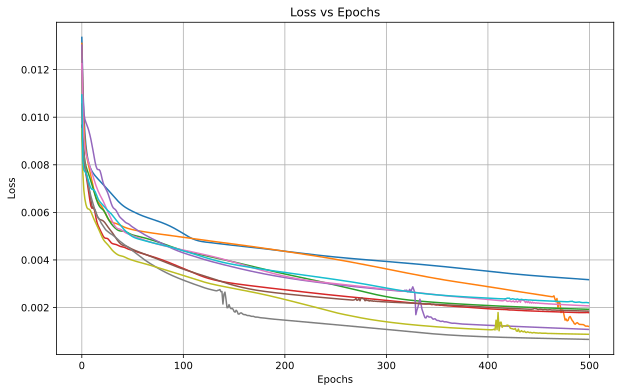

In [15]:
all_losses = best_loss_overall
best_model_pars = best_pars_overall
min_loss = best_rf_overall

print(f"min loss: {min_loss}")

# Plotting the loss values
plt.figure(figsize=(10, 6))

# Plot the loss values for each iteration
for i, loss_values in enumerate(all_losses):
    plt.plot(loss_values, label=f'Iteration {i+1}')

plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Print the best model parameters
print("Best model parameters:")
for i, par in enumerate(best_model_pars):
    print(f"Parameter {i+1}: {par.numpy():.8f}")
    
# Print the model summary
print("Maximum parameter value:", max_par_value)
print("Number of iterations:", n_iter)
print("Number of features:", n_features)
model.summary()
modes = get_mode_amplitudes_p63(*best_model_pars)
print("Modes:")
for key, val in modes.items():
    print(f"{key}: {val*1000:.4f}")

Best model parameters:
Parameter 1: 0.00750547
Parameter 2: 0.00470715
Parameter 3: 0.00219622
Parameter 4: 0.00046896
Parameter 5: 0.00380687
Parameter 6: -0.00078371
Parameter 7: -0.00610578
Parameter 8: -0.00532861
Parameter 9: 0.00268208
Parameter 10: -0.00000868
Parameter 11: 0.00354153
Parameter 12: -0.00171487
Parameter 13: 0.00068843
Parameter 14: 0.00235418
Parameter 15: 0.01296547
Parameter 16: -0.00473257
Parameter 17: 0.00040569
Parameter 18: 0.00818263
Parameter 19: -0.00172988
Parameter 20: -0.00094236
Parameter 21: 0.00191189
Parameter 22: 0.00133301
Parameter 23: -0.00139377
Parameter 24: -0.00054459
Parameter 25: -0.00044380
Parameter 26: 0.00710835
Parameter 27: -0.00376826
Parameter 28: -0.00633892
Parameter 29: 0.00211521
Parameter 30: -0.00102417
Parameter 31: -0.01085931
Parameter 32: -0.00311346
Parameter 33: -0.00080467
Parameter 34: -0.00357306
Parameter 35: 0.00306355
Parameter 36: 0.00754958
Parameter 37: 0.00111379
Parameter 38: 0.00130889
Parameter 39: 0.00

In [19]:
def plot_plane_sim_vs_exp(ax, df, l, norm_plane=False):
    exp_data_0 = df.loc[df['l'] == l].copy()
    if norm_plane:
        exp_data_0['intensity_sim'] = exp_data_0['intensity_sim'] / np.max(exp_data_0['intensity_sim'])
        exp_data_0['intensity_exp'] = exp_data_0['intensity_exp'] / np.max(exp_data_0['intensity_exp'])
    
    ax.scatter(exp_data_0['h'], exp_data_0['k'], 
               s=exp_data_0['intensity_sim'] * 1500, color='red', edgecolor="black",
               label='Sim', marker=MarkerStyle("o", fillstyle="left"))
    ax.scatter(exp_data_0['h'] , exp_data_0['k'] , s=exp_data_0['intensity_exp'] * 1500  , color='blue', edgecolor="black",
               label='Exp', marker=MarkerStyle("o", fillstyle="right"))
    #ax.scatter(exp_data_0['h'], -exp_data_0['k'], 
               #s=exp_data_0['intensity_exp'] * 300, color='blue', edgecolor="black",
               #label='Exp', marker=MarkerStyle("o", fillstyle="right"))
    
    #grid on
    ax.grid(True, linestyle='--', alpha=0.7)
    #adjust x axis ticks
    ax.set_xticks(np.arange(0, 5, 0.11))
    ax.set_yticks(np.arange(0, 5, 0.11))
    ax.set_xlabel(f"h in (h, k, {l}) [r.l.u.]")
    ax.set_ylabel(f"k in (h, k, {l}) [r.l.u.]")
    '''if data_char == 'best':
        ax.set_title(f"l = {l}, best")
    else:
        ax.set_title(f"l = {l} , current")'''
    ax.legend()

In [17]:
#exp_data = pd.read_csv('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/raw_data/peaks.csv')
exp_data = pd.read_csv('C:/Users/Calculations/Documents/alris/CrystalClearFit/alrisDistortionFit/raw_data/peaks.csv')
exp_data['intensity_sim'] = fun_tf(features, best_model_pars).numpy()

Shape of sf_combined: (217,), Shape of x_combined: (217, 3)


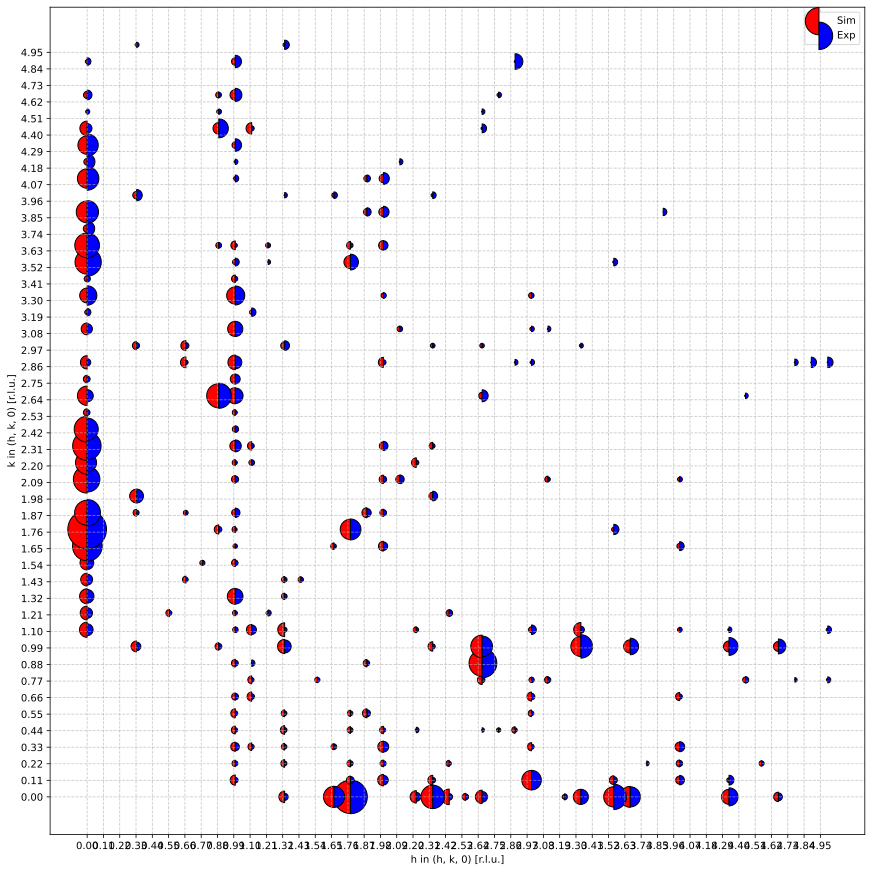

In [20]:
fig, axs = plt.subplots(1, 1, figsize=(12, 12), constrained_layout=True)
plot_plane_sim_vs_exp(axs, exp_data, 0, norm_plane=True)
plt.show()



In [21]:
#save the experiment data with simulated intensities
exp_data.to_csv('C:/Users/Calculations/Documents/alris/CrystalClearFit/alrisDistortionFit/fitted_data/peaks_with_simulated_intensities.txt', index=False)

#save all the parameters and the modes
with open('C:/Users/Calculations/Documents/alris/CrystalClearFit/alrisDistortionFit/fitted_data/parameters_and_modes.txt', 'w') as f:
    f.write(f"final loss: {min_loss:.8f}\n")
    f.write(f"learning_rate: {lr[0]:.8f}\n")
    f.write(f"n_epochs: {n_epochs}\n")
    f.write(f"Best model parameters:\n")
    for i, par in enumerate(best_model_pars):
        f.write(f"Parameter {i+1}: {par.numpy():.8f}\n")
    for key, val in modes.items():
        f.write(f"{key}: {val*1000:.4f}\n")


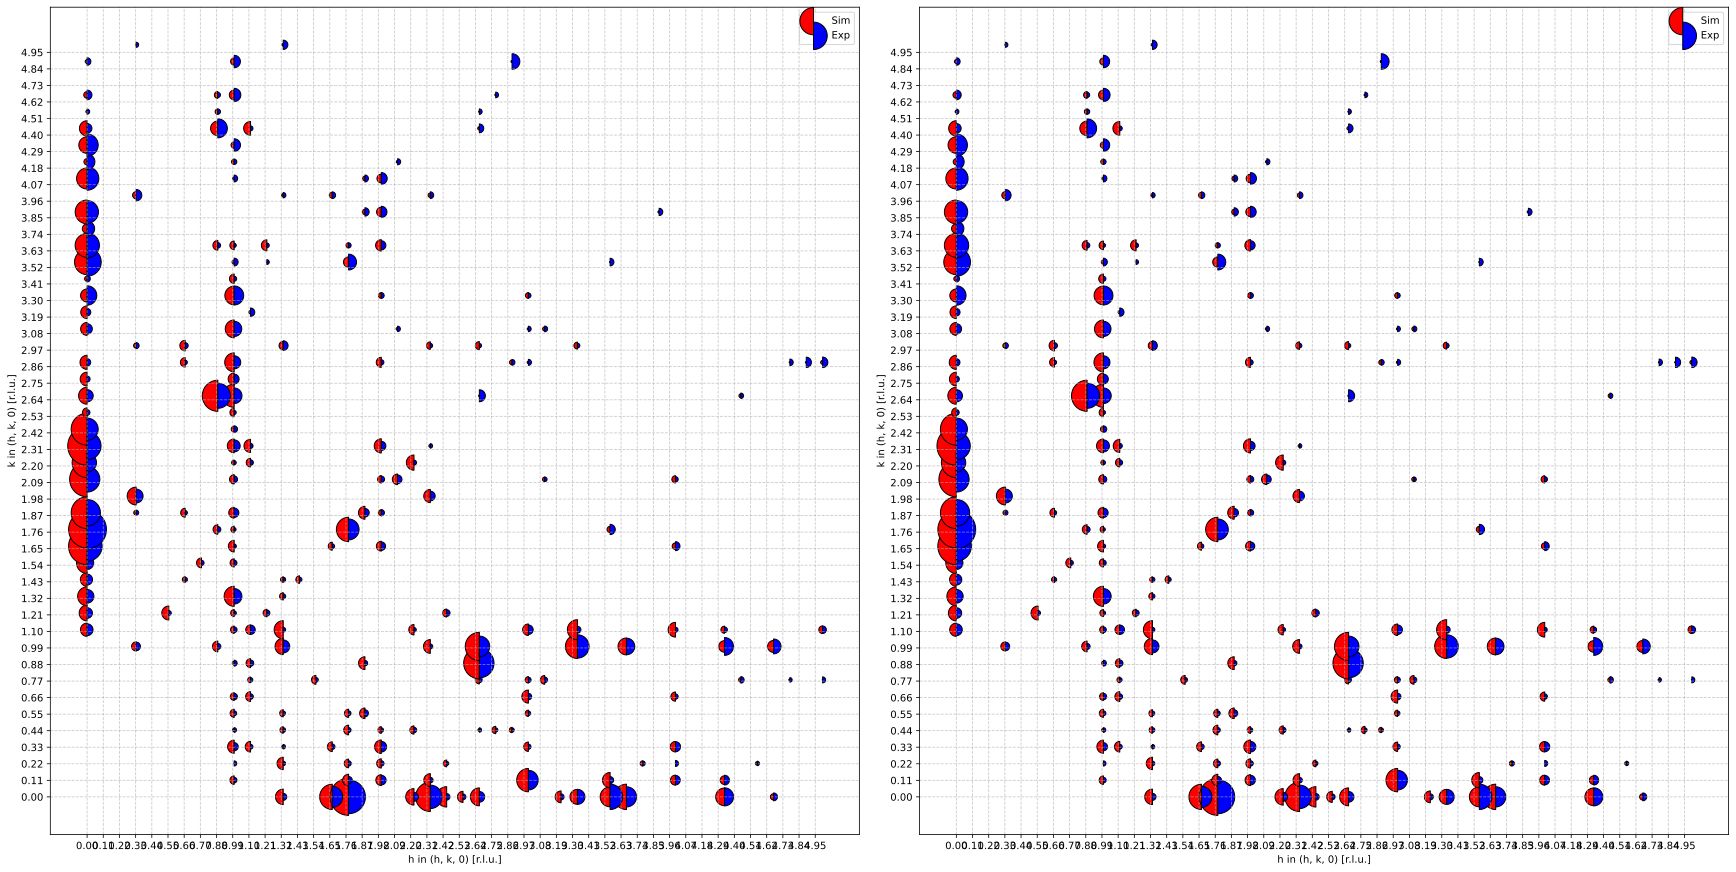

In [ ]:
#best_data = pd.read_csv('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/fitted_data/peaks_with_simulated_intensities.txt')
best_data = pd.read_csv('C:/Users/Calculations/Documents/alris/CrystalClearFit/alrisDistortionFit/fitted_data/peaks_with_simulated_intensities.txt')
fig, axs = plt.subplots(1, 2, figsize=(24, 12), constrained_layout=True)
plot_plane_sim_vs_exp(axs[0], best_data, 0, norm_plane=True)
plot_plane_sim_vs_exp(axs[1], exp_data, 0, norm_plane=True)

plt.show()